# Installation

it will take some minutes to install GMT in colab

In [1]:
import sys
if 'google.colab' in sys.modules:
    !sudo apt update 
    !sudo apt upgrade -y
    !sudo apt install -y build-essential cmake libcurl4-gnutls-dev libnetcdf-dev gdal-bin libgdal-dev libfftw3-dev libpcre3-dev liblapack-dev libblas-dev libglib2.0-dev ghostscript ghostscript-x graphicsmagick ffmpeg xdg-utils
    # clone gmt from source
    !git clone --depth 50 https://github.com/GenericMappingTools/gmt
    # cmake everything
    !cmake /content/gmt
    # build and install
    !cmake --build . --target install

    !pip install pygmt geopandas geopandas openpyxl obspy ipykernel
    !git clone https://github.com/ecastillot/EQViewer.git /content/EQViewer

**Please restart your kernel**. And then, enjoy the following

In [2]:
import sys
import os
if 'google.colab' in sys.modules:
    repository_path = r"/content/EQViewer"  
else:
    repository_path = r"/home/emmanuel/EQViewer"  ##change this path where is located the main directory

sys.path.insert(0,repository_path)
rep_data = os.path.join(repository_path,"data")
rep_out = os.path.join(repository_path,"docs","figures")

# Profile
In this notebook, you will see some examples to manipulate the Profile object. You will learn how to plot different objects in the profile, such as [Catalog](https://github.com/ecastillot/EQViewer/blob/master/examples/3_catalog.ipynb), [Well](https://github.com/ecastillot/EQViewer/blob/master/examples/4_well.ipynb) and [Focal mechanism](https://github.com/ecastillot/EQViewer/blob/master/examples/5_fm.ipynb).

In [3]:
from EQViewer.eqviewer import Profile, BaseProfile

Profile receives the coordinates where it will be traced along with the respective name, it also receives the width. Finally, baseprofile parameters is the base to plot the profile, where we must indicate the projection, limits, and the output unit.

Using projection="X10/-6" sets the width for 10cm and height to 6cm. Using a lower-case "x" specifies that you are setting the scale rather than the width. e.g., projection="x0.1c/0.1c" to set x- and y- scales to 0.1 cm per data unit. [(Explanation)](https://forum.generic-mapping-tools.org/t/making-x-and-y-axis-to-have-the-same-scale/2696/2?u=ecastillot) 



In [4]:

baseprofile = BaseProfile(projection="x5c/-5c",depth_lims =[0,4],
                        grid=(1,1),
                        output_unit="km")
profile = Profile(name=("A","A'"),      
            coords=((-122.88243,38.85673),(-122.69410,38.78445)),
            width=(-1.5,1.55),
            baseprofile=baseprofile
                )
print(profile.__str__(True))

Profile  A-A' 
	A: (-122.88243, 38.85673)
	A': (-122.6941, 38.78445)
	width: (-1.5, 1.55) m
	output_unit: km


Now, we will add some objects to the profile, it will project each one. Take a look to the explanations of [MulCatalog](https://github.com/ecastillot/EQViewer/blob/master/examples/3_catalog.ipynb), [MullWell](https://github.com/ecastillot/EQViewer/blob/master/examples/4_well.ipynb) and [MulFM](https://github.com/ecastillot/EQViewer/blob/master/examples/5_fm.ipynb)

In [5]:
from EQViewer.eqviewer import (Catalog,Well,FM,Injection,
                                MulCatalog,MulWell,MulFM,
                                BaseMeca,BasePlot,CPT)
import pandas as pd
import numpy as np

Let us define our region

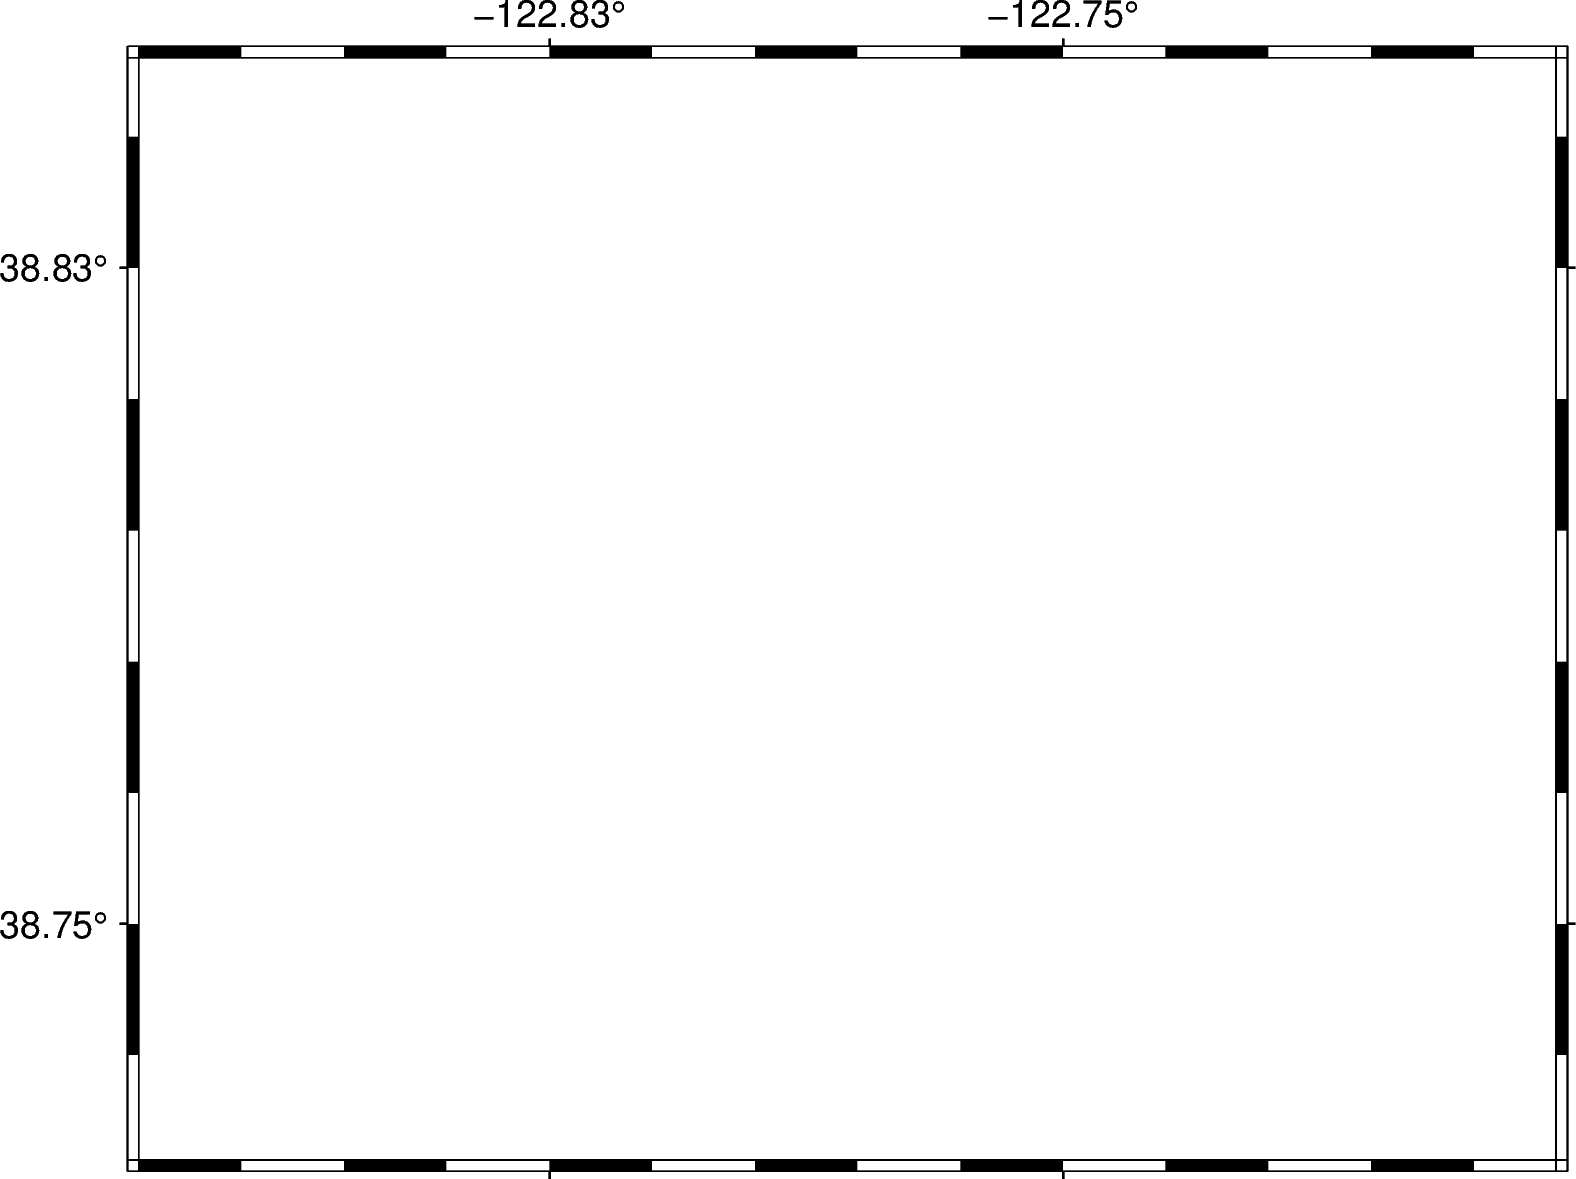

In [6]:
import pygmt

basefig = pygmt.Figure() 
basefig.basemap(region=[-122.9,-122.67,38.72,38.86],
            projection="M12c", 
            frame=["af","WNse"])
basefig.show()

Let us define the objects to project in our profile

## Adding catalog

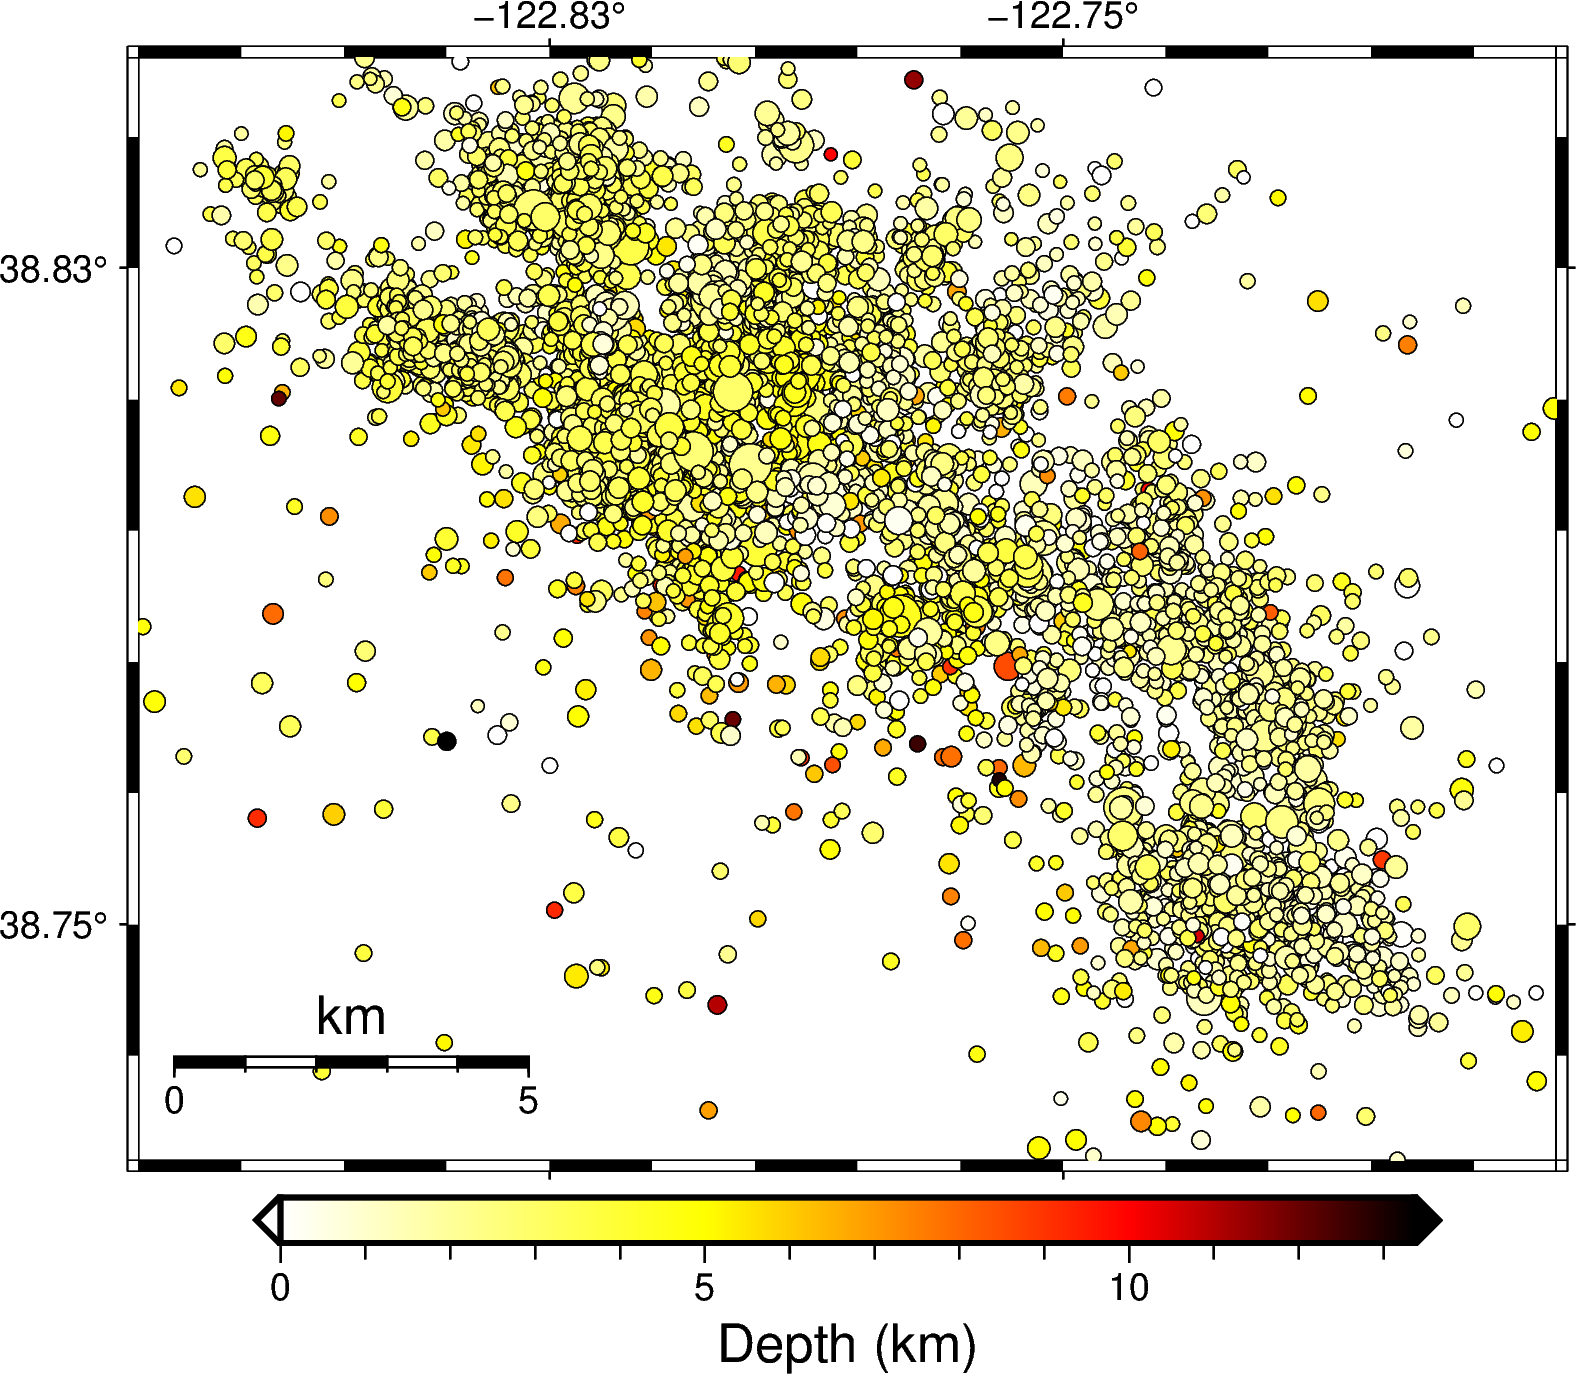

In [7]:
catalogpath = os.path.join(rep_data,"earthquakes","catalog.csv")
df = pd.read_csv(catalogpath,parse_dates=["origin_time"])
cat_baseplot = BasePlot(color = "gray",
                    style="cc",
                    size=lambda x: 0.11 * np.sqrt(1.8 ** (x.magnitude*1.4)),
                    cmap = True,
                    pen = "black")
catalog = Catalog(data=df,baseplot=cat_baseplot)
cat_cpt = CPT(color_target="depth",
                label="Depth (km)",
                cmap="hot",
                series=[catalog.data.depth.min(),
                        catalog.data.depth.max()],
                reverse=True,
                overrule_bg=True)

mulcatalog = MulCatalog([catalog],cpt=cat_cpt,show_cpt=True)

mulcatfig = mulcatalog.plot_map(fig=basefig)
mulcatfig.basemap(map_scale=f"jBL+o0.3c/0.7c+w{5}k+f+lkm+at")
mulcatfig.show()

## Adding well with injection

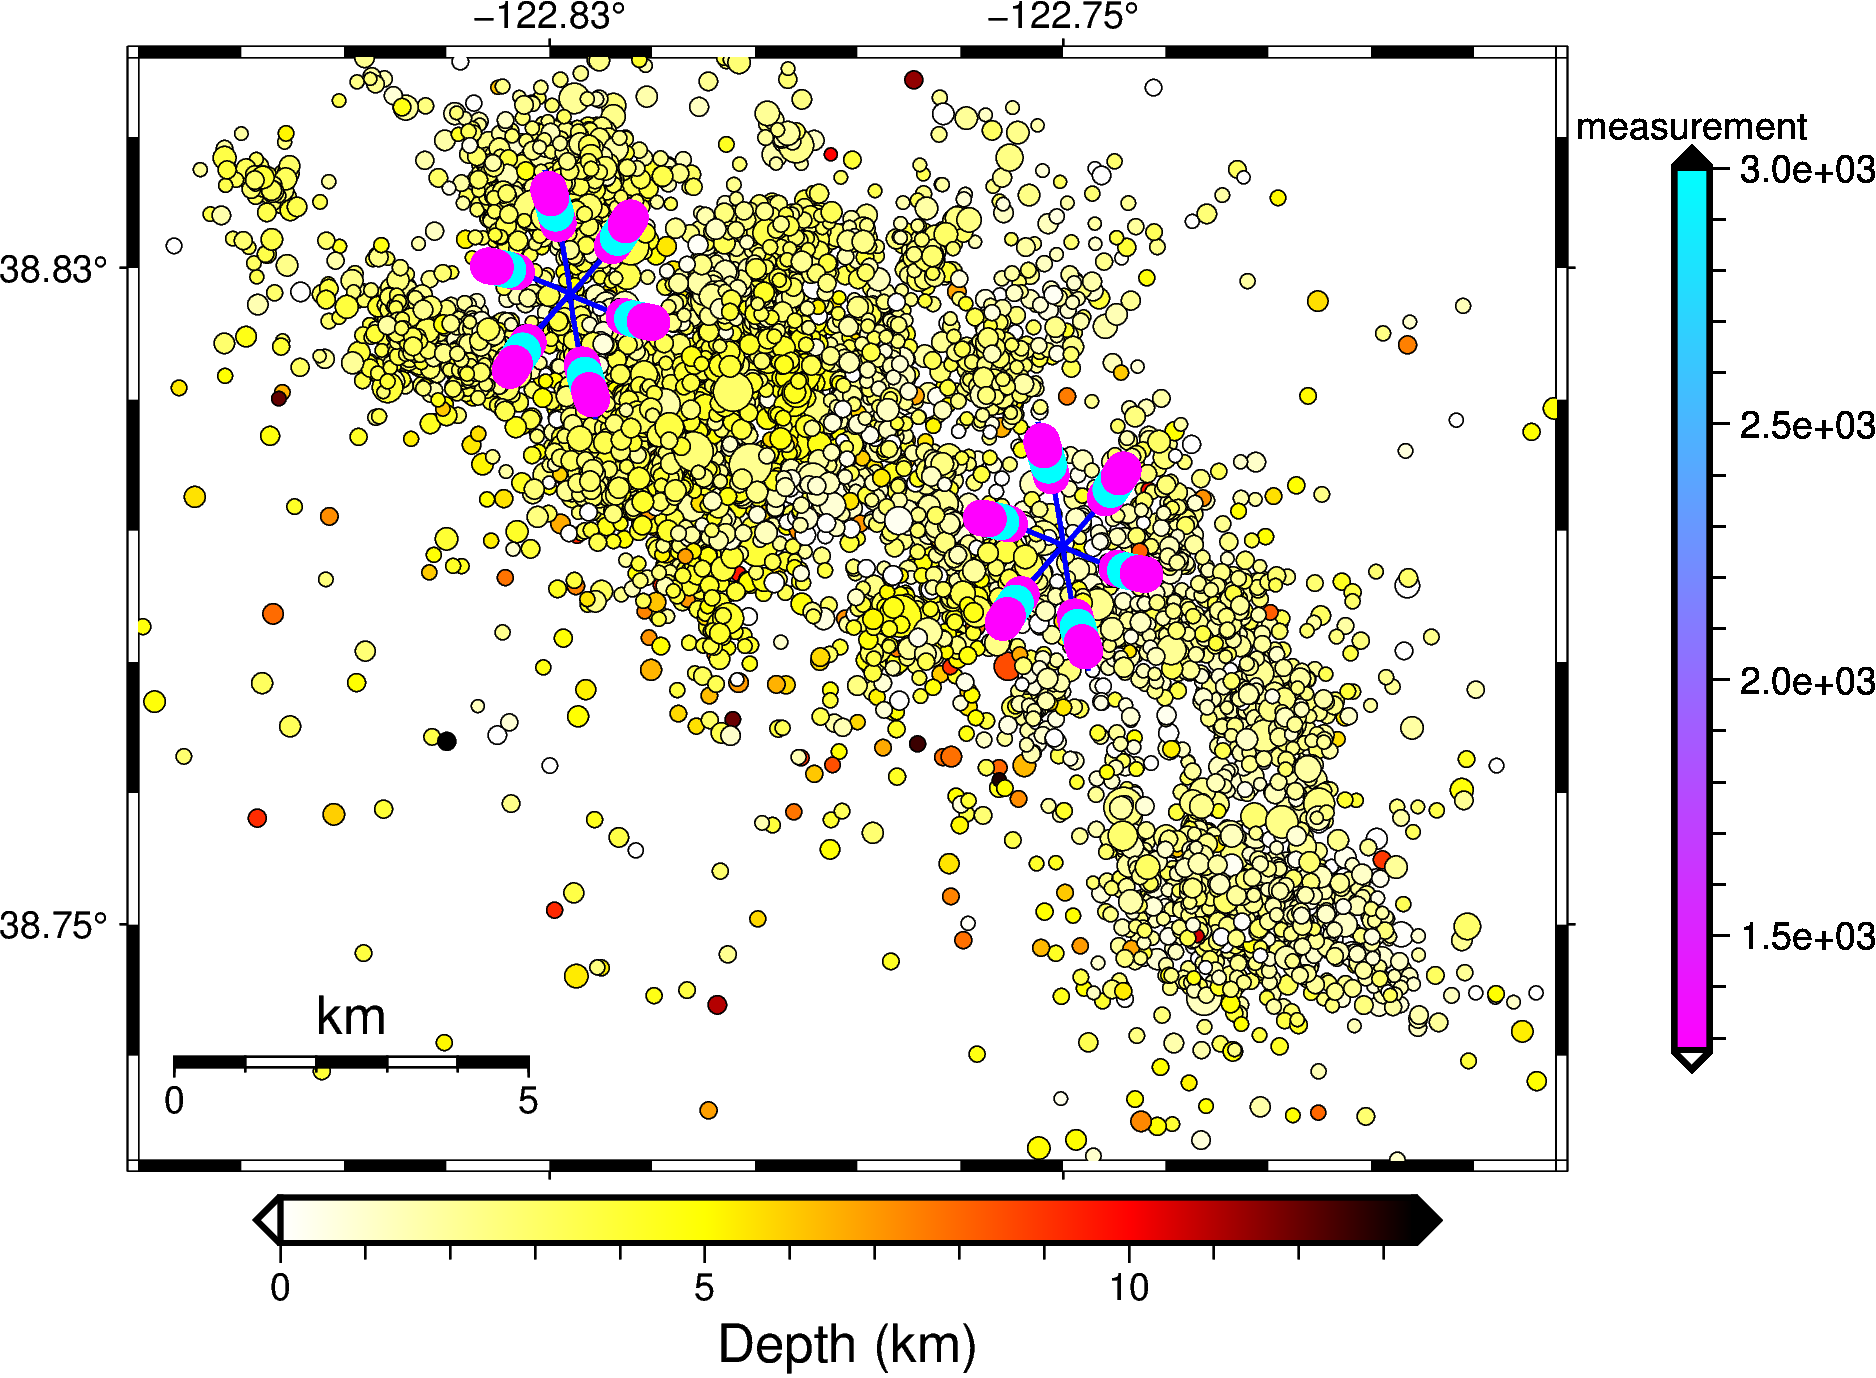

In [8]:
import glob

injectionpath = os.path.join(rep_data,"wells","injection","injection.csv")
inj_df = pd.read_csv(injectionpath)
inj_baseplot=BasePlot(color="blue",
                    pen="5p,blue",
                    cmap=False)

inj = Injection(data=inj_df,depth_type="TVD",
                    baseplot=inj_baseplot)


survey_path = os.path.join(rep_data,"wells","survey")

well_baseplot = BasePlot(color = None,
                    style=None,
                    cmap = False,
                    pen = "1p,blue",
                    label="well_survey")
inj_baseplot=BasePlot(color="blue",
                    style="c0.3c",
                    pen=None,
                    cmap=True)

inj = Injection(data=inj_df,depth_type="TVD",
                    baseplot=inj_baseplot)

inj_cpt = CPT(color_target="measurement",
                label="Water flow",
                cmap="cool",
                series=[inj.data.measurement.min(),
                        inj.data.measurement.max()],
                reverse=True,
                overrule_bg=True)

wells = []
for path in glob.glob(os.path.join(survey_path,"*")):
    df = pd.read_csv(path)
    wellname = os.path.basename(path).split(".")[0]
    well_with_inj = Well(data=df,name=wellname,
                        baseplot=well_baseplot,injection=inj)
    wells.append(well_with_inj)
mulwell = MulWell(wells)

mulwellfig = mulwell.plot_map(fig=mulcatfig)
mulwellfig.show()

## Adding FM

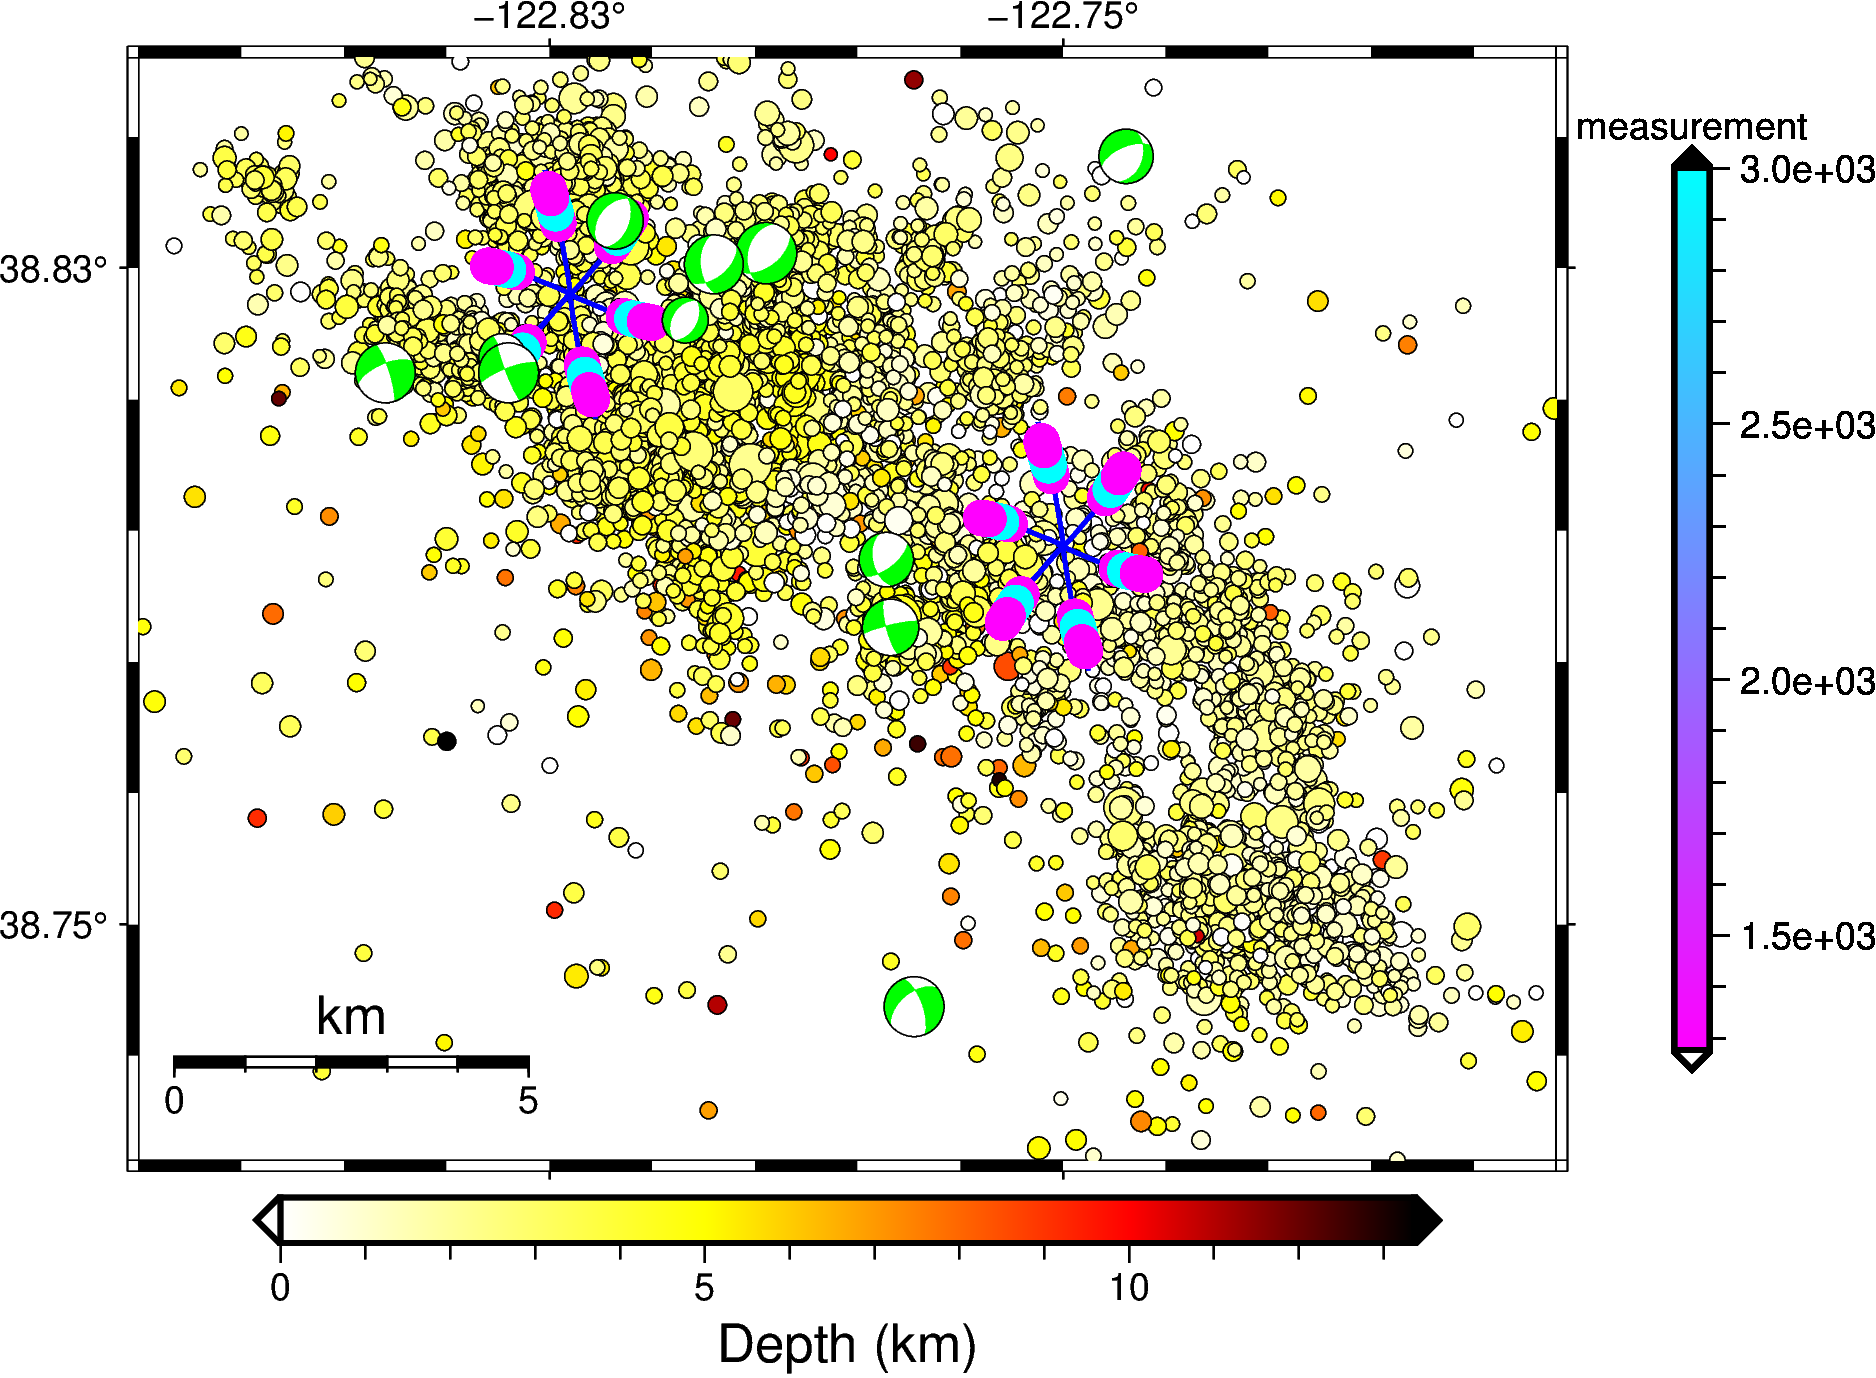

In [9]:
fmpath = os.path.join(rep_data,"fm","fm.csv")
df = pd.read_csv(fmpath)

basemeca = BaseMeca(scale="0.5c",color="green",cmap=False,
                transparency=None)
fm = FM(data=df,basemeca=basemeca)
mulfm = MulFM([fm])

mulfmfig = fm.plot_map(fig=mulwellfig)
mulfmfig.show()

## Plot profile in map

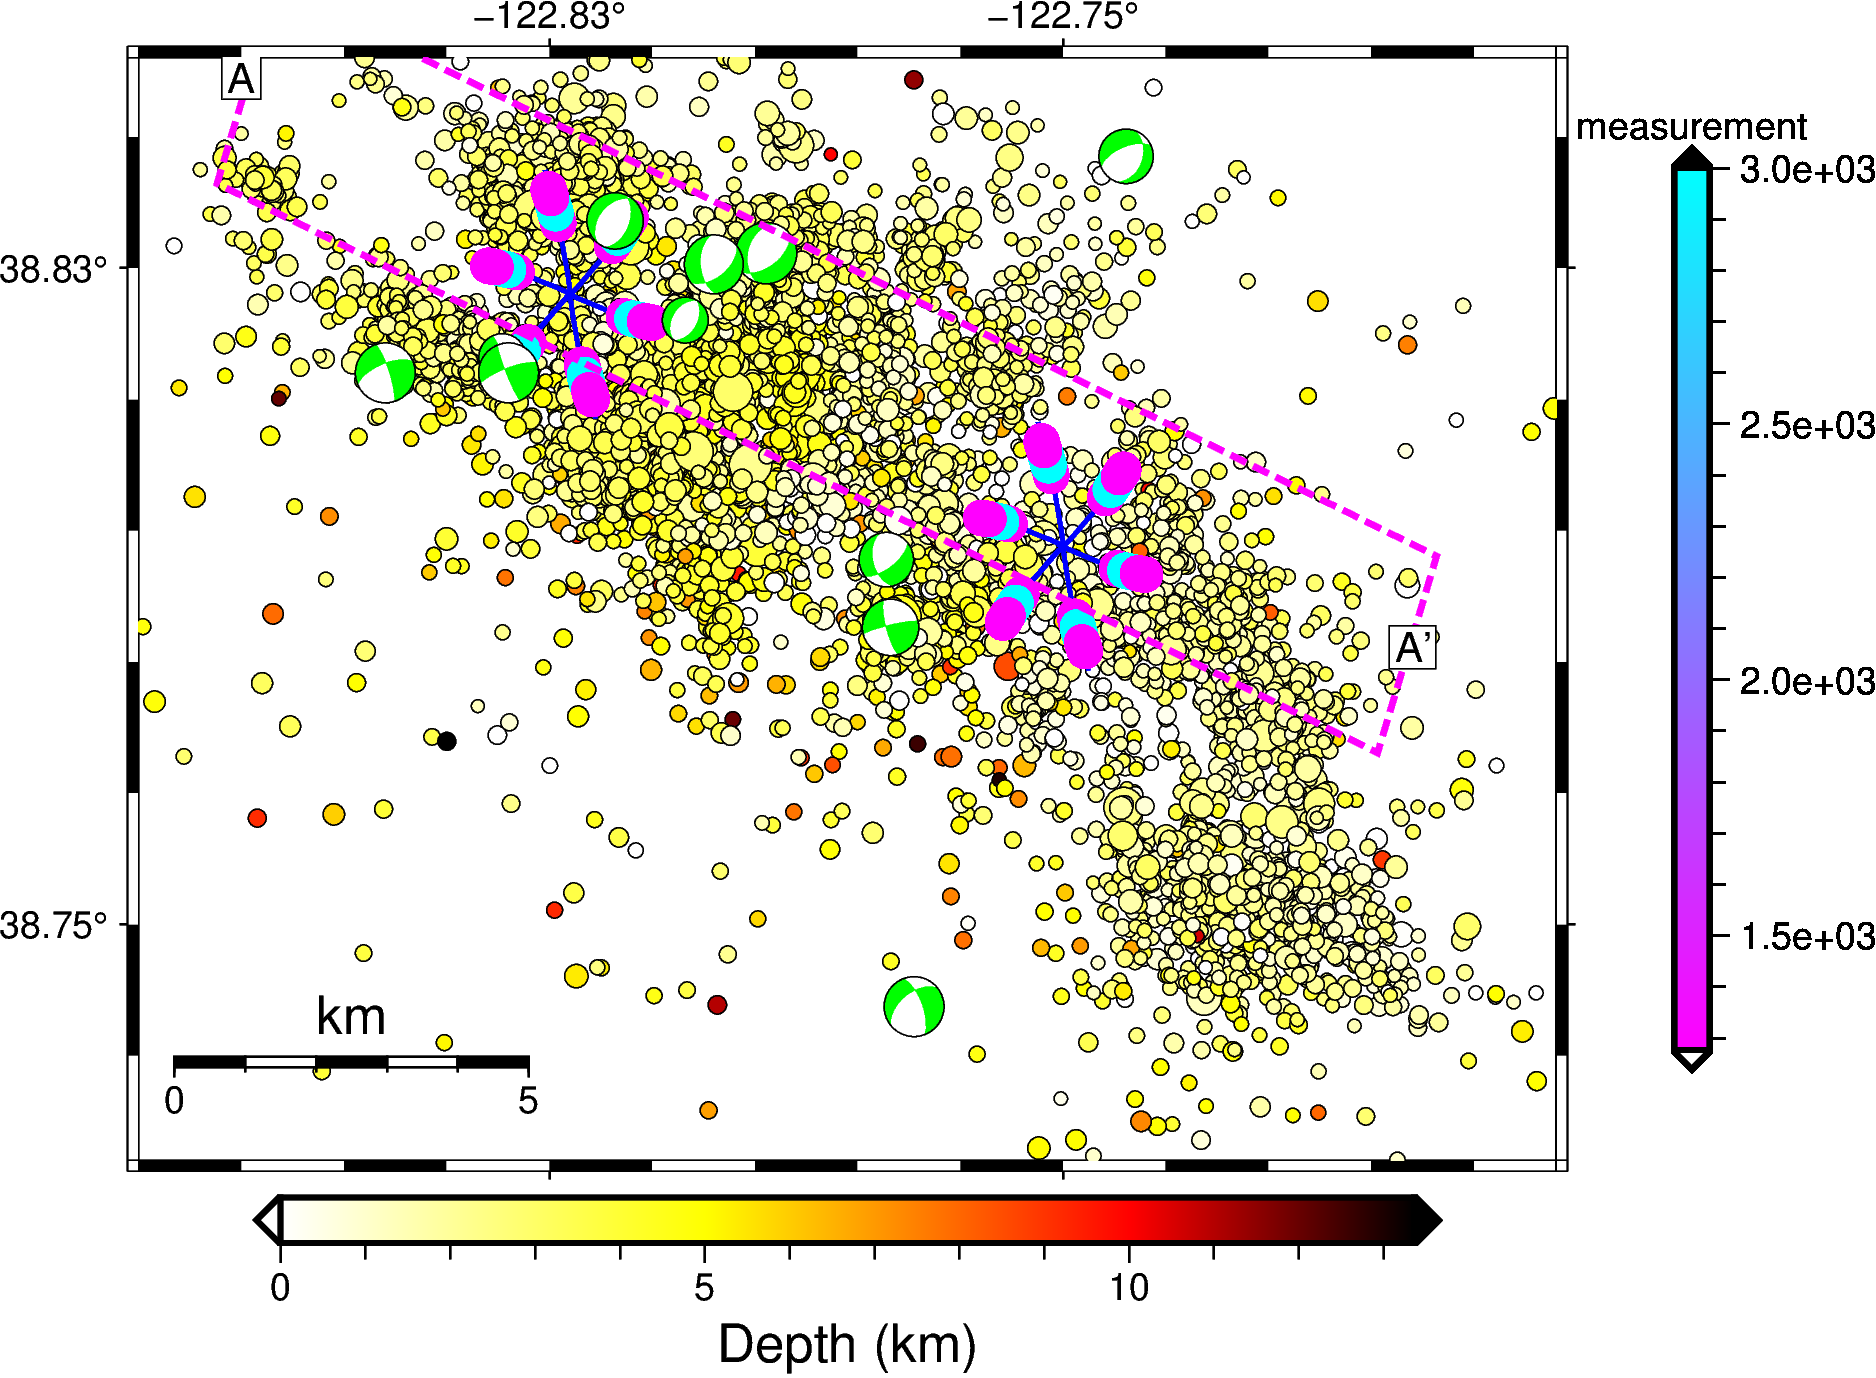

In [10]:
profilefig = profile.plot_in_map(fig=mulfmfig,rescale=False)
profilefig.show()

## Plot profile
Now, we are ready to plot our profile

In [11]:
profile.add_mulobject(mulcatalog,depth_unit="km")
profile.add_mulobject(mulwell,depth_unit="m")
profile.add_mulobject(mulfm,depth_unit="km")

project [INFORMATION]: Processing input table data
project [INFORMATION]: Reading Data Table from Input memory location via vector
project [INFORMATION]: Writing Data Table to file /tmp/pygmt-ikl9rkz4.csv
project [INFORMATION]: 9998 read, 4695 used
project [INFORMATION]: Processing input table data
project [INFORMATION]: Reading Data Table from Input memory location via vector
project [INFORMATION]: Writing Data Table to file /tmp/pygmt-m4av6_7f.csv
project [INFORMATION]: 92 read, 92 used
project [INFORMATION]: Processing input table data
project [INFORMATION]: Reading Data Table from Input memory location via vector
project [INFORMATION]: Writing Data Table to file /tmp/pygmt-gxcc57qi.csv
project [INFORMATION]: 92 read, 92 used
project [INFORMATION]: Processing input table data
project [INFORMATION]: Reading Data Table from Input memory location via vector
project [INFORMATION]: Writing Data Table to file /tmp/pygmt-i6btewmr.csv
project [INFORMATION]: 92 read, 74 used
project [INFORMA

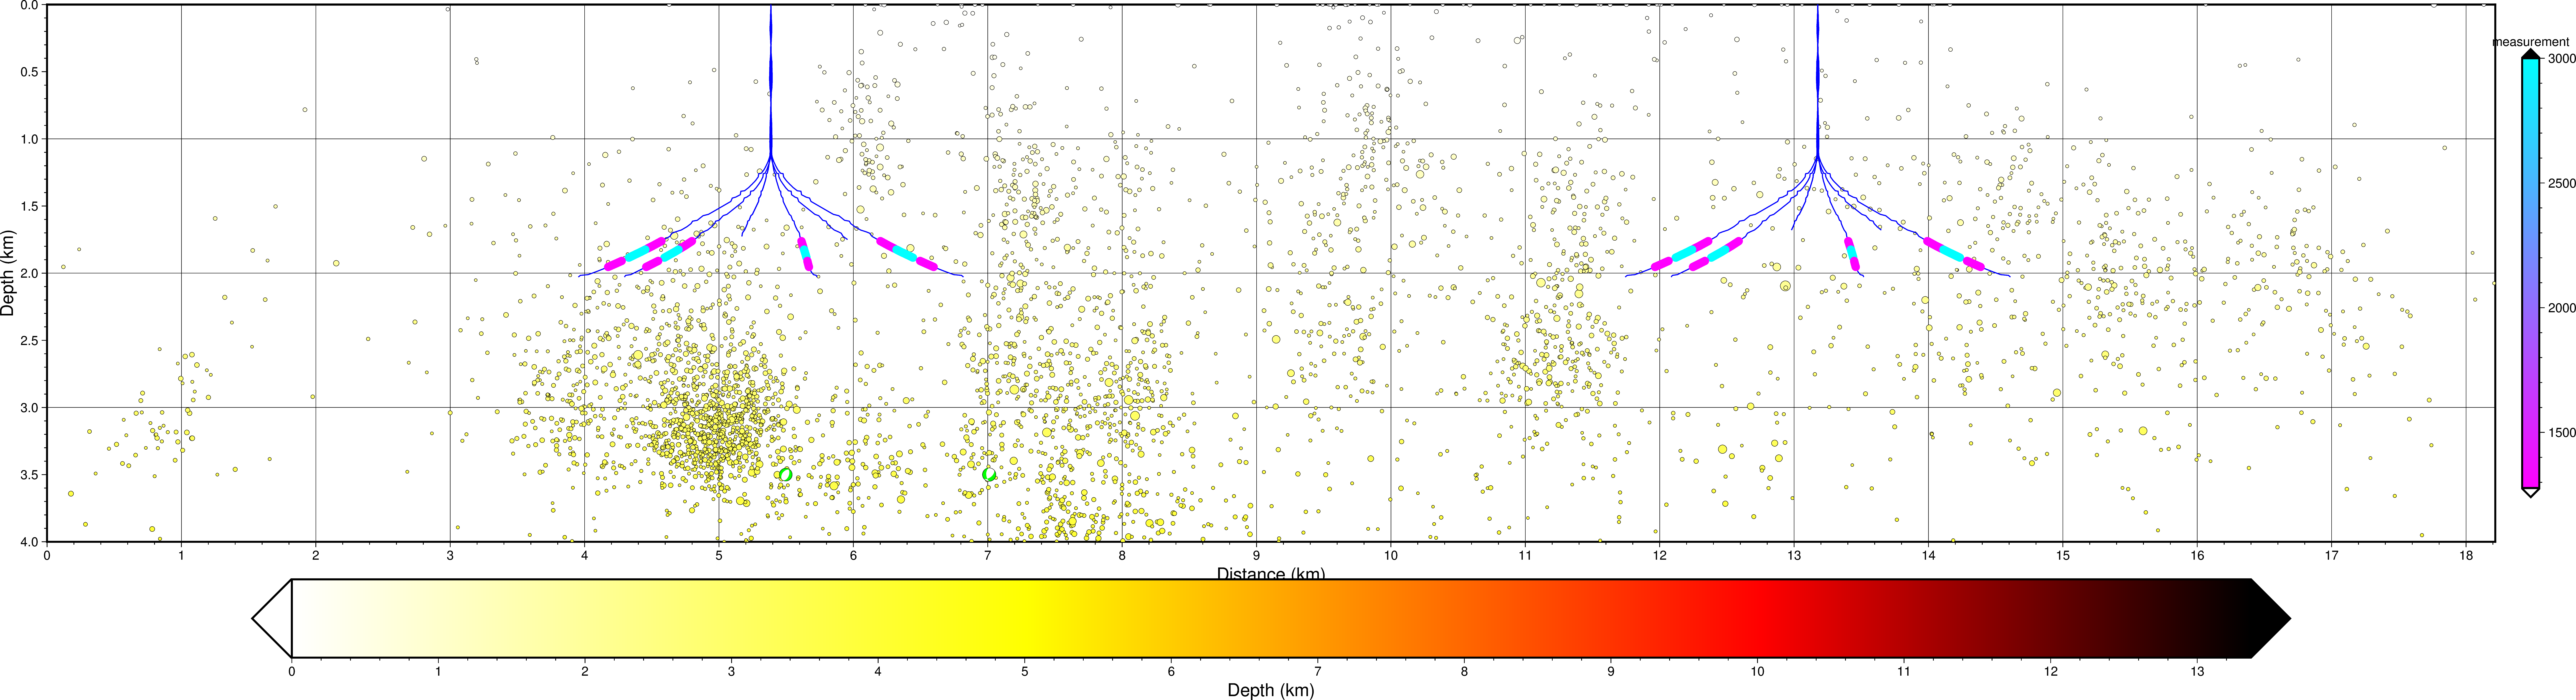

In [12]:
profig = profile.plot()
profig.show()

This figure was drawn to scale. To have a better image, we will plot defining the size of the figure.

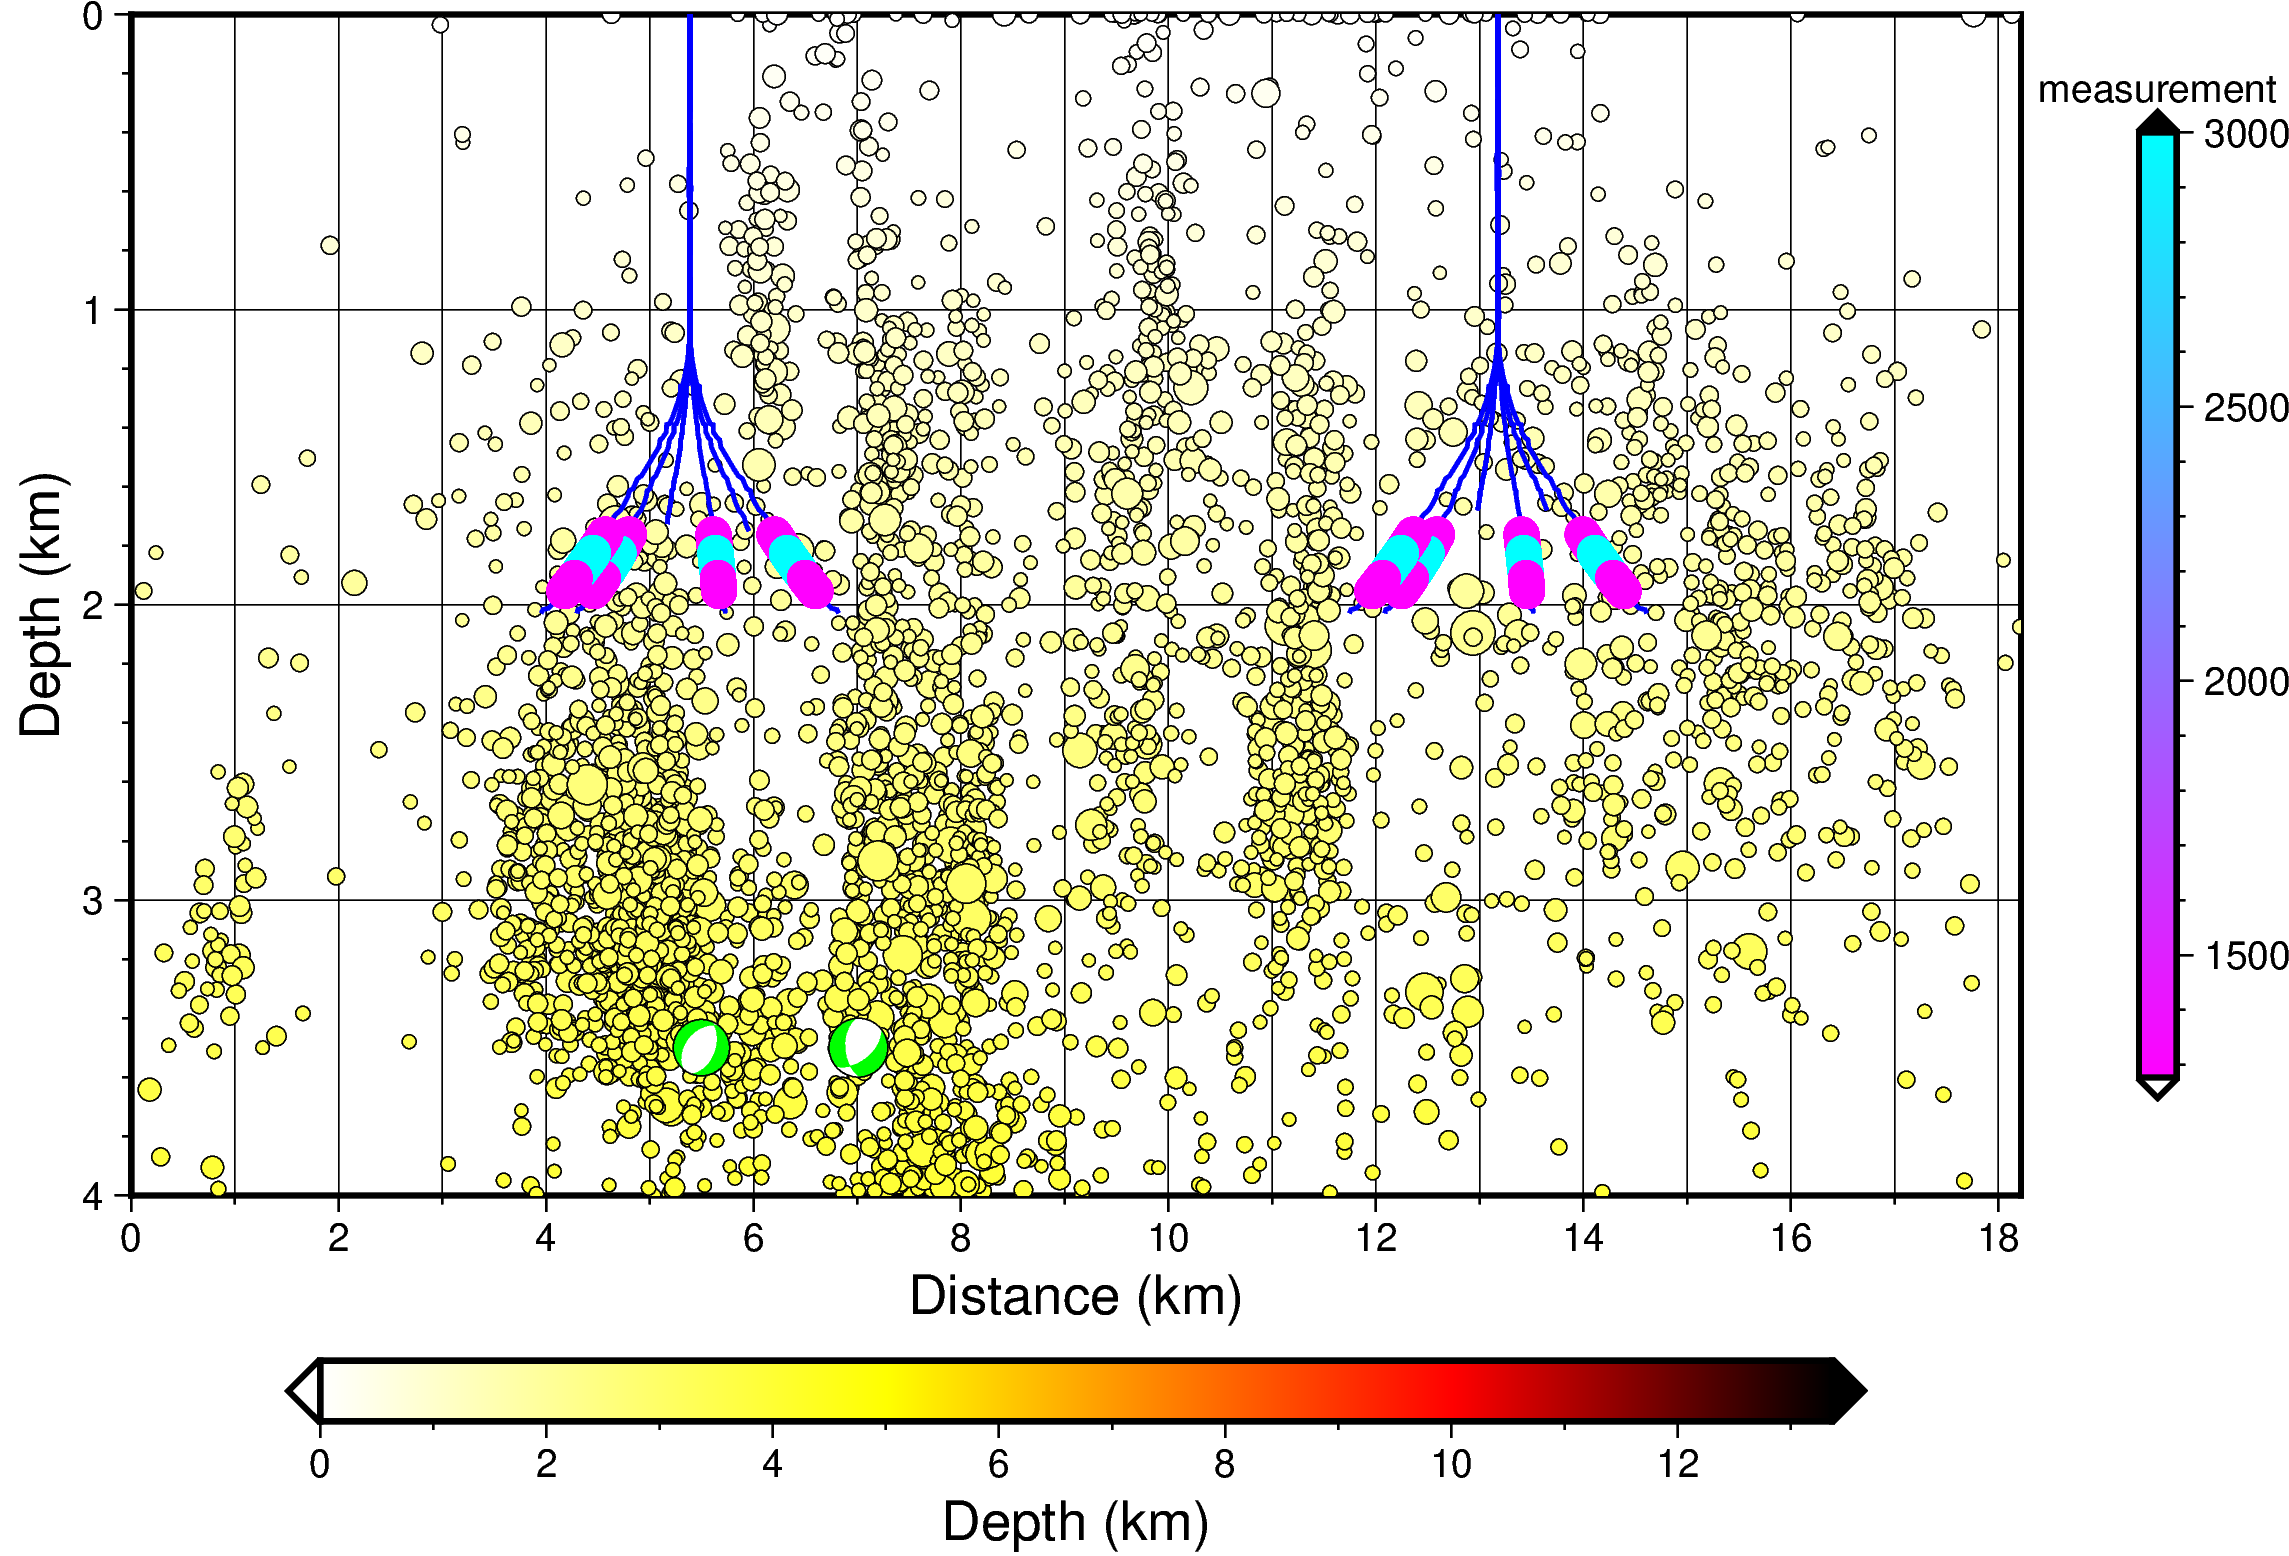

In [13]:
sameprofile = profile.copy()
sameprofile.baseprofile.projection = "X16c/-10c"
sameprofig = sameprofile.plot()
sameprofig.show()

# Other example

Take a look in this other beautiful analysis using other mulcatalog

## other catalog

Take a look in this [example](https://github.com/ecastillot/EQViewer/blob/master/examples/3_catalog.ipynb) to reproduce the next catalog

In [14]:
catalogpath = os.path.join(rep_data,"earthquakes","catalog.csv")
df = pd.read_csv(catalogpath,parse_dates=["origin_time"])

cat_baseplot = BasePlot(color = "gray",
                    style="c0.1c",
                    size=None,
                    cmap = False,
                    pen = "black",
                    label="all_events")
catalog = Catalog(data=df,baseplot=cat_baseplot)

filter_domain=[-122.92462,-122.76703,38.74915,38.88327]
pol2filter = [(filter_domain[0],filter_domain[2]),
                (filter_domain[0],filter_domain[3]),
                (filter_domain[1],filter_domain[3]),
                (filter_domain[1],filter_domain[2]),
                (filter_domain[0],filter_domain[2])
                ]
catalog1 = catalog.copy()
catalog1.filter_region(polygon=pol2filter)
catalog1.baseplot.style = "c0.2c"
catalog1.baseplot.color = "yellow"
catalog1.baseplot.cmap = False
catalog1.baseplot.label = "Group_1"

filter_domain=[-122.76647,-122.65638,38.74915 ,38.85847] 
pol2filter = [(filter_domain[0],filter_domain[2]),
                (filter_domain[0],filter_domain[3]),
                (filter_domain[1],filter_domain[3]),
                (filter_domain[1],filter_domain[2]),
                (filter_domain[0],filter_domain[2])
                ]
catalog2 = catalog.copy()
catalog2.filter_region(polygon=pol2filter)
catalog2.baseplot.style = "c0.2c"
catalog2.baseplot.color = "red"
catalog2.baseplot.cmap = False
catalog2.baseplot.label = "Group_2"

filter_domain=[-122.75026,-122.56920,38.68506 ,38.80840]  
pol2filter = [(filter_domain[0],filter_domain[2]),
                (filter_domain[0],filter_domain[3]),
                (filter_domain[1],filter_domain[3]),
                (filter_domain[1],filter_domain[2]),
                (filter_domain[0],filter_domain[2])
                ]
catalog3 = catalog.copy()
catalog3.filter_region(polygon=pol2filter)
catalog3.baseplot.style = "c0.2c"
catalog3.baseplot.color = "seagreen"
catalog3.baseplot.cmap = False
catalog3.baseplot.label = "Group_3"

othermulcatalog = MulCatalog(catalogs=[catalog1,catalog2,catalog3])
print(othermulcatalog)

Catalogs (3 catalogs)
----------------------
1. Catalog | 7158 events 
2. Catalog | 2360 events 
3. Catalog | 2023 events 


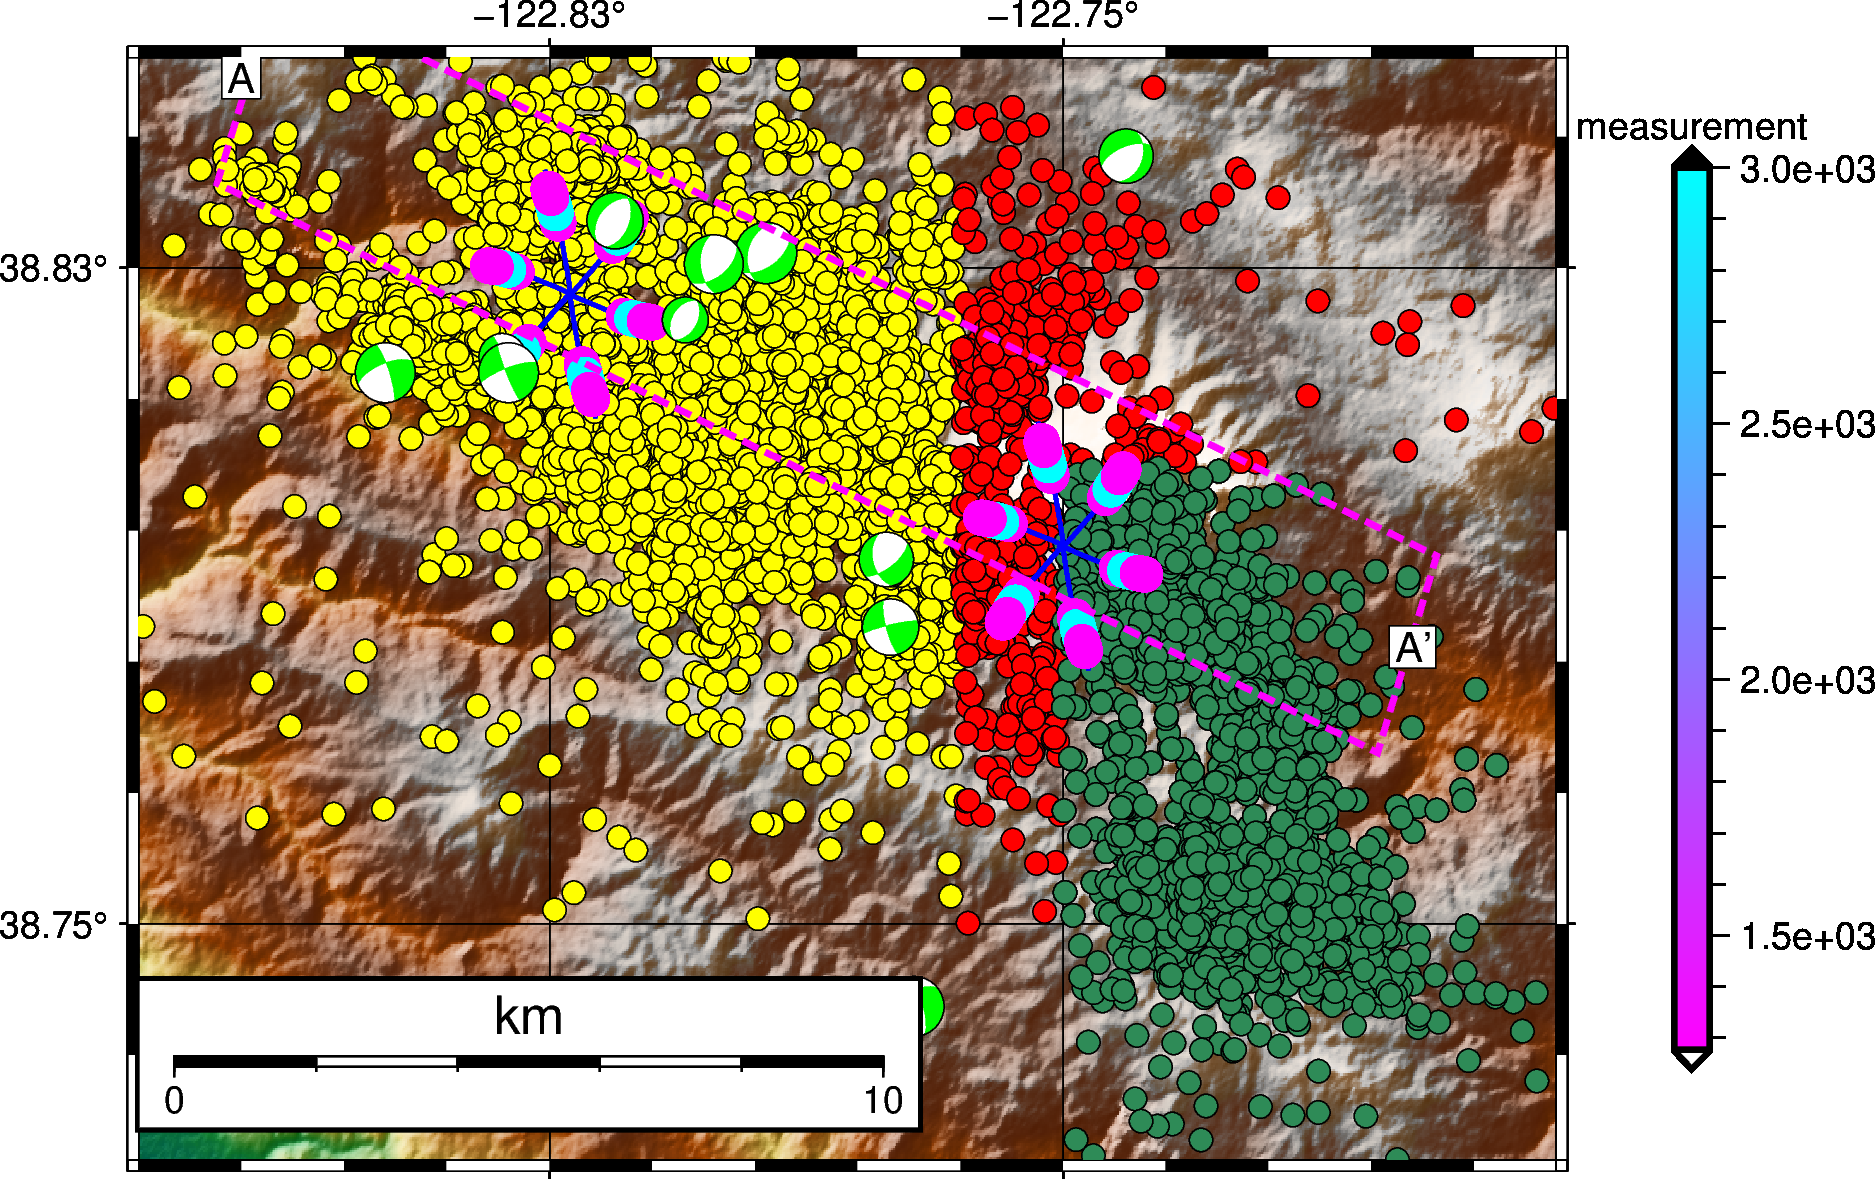

In [15]:
import pygmt

otherfig = pygmt.Figure() 
otherfig.basemap(region=[-122.9,-122.67,38.72,38.86],
            projection="M12c", 
            frame=["af","WNse"])
otherfig.grdimage(
            '@earth_relief_01s', #01m resolution 
            cmap=True,
            shading=True,
            frame=["afg","WNse"]
        )
otherfig.coast(
            shorelines=True,
            borders='1/1p,black',
            frame=["afg","WNse"],
        )
othercatfig = othermulcatalog.plot_map(otherfig)
othermulwellfig = mulwell.plot_map(fig=othercatfig)
othermulfmfig = fm.plot_map(fig=othermulwellfig)
otherprofilefig = profile.plot_in_map(fig=othermulfmfig,rescale=False)
otherprofilefig.basemap(map_scale=f"jBL+o0.3c/0.7c+w{10}k+f+lkm+at",box='+gwhite+p1p')
otherprofilefig.savefig(os.path.join(rep_out,"map.png"))
otherprofilefig.show()

project [INFORMATION]: Processing input table data
project [INFORMATION]: Reading Data Table from Input memory location via vector
project [INFORMATION]: Writing Data Table to file /tmp/pygmt-xlsc3hsr.csv
project [INFORMATION]: 7158 read, 3693 used
project [INFORMATION]: Processing input table data
project [INFORMATION]: Reading Data Table from Input memory location via vector
project [INFORMATION]: Writing Data Table to file /tmp/pygmt-wiv0du48.csv
project [INFORMATION]: 2360 read, 977 used
project [INFORMATION]: Processing input table data
project [INFORMATION]: Reading Data Table from Input memory location via vector
project [INFORMATION]: Writing Data Table to file /tmp/pygmt-ndglqj27.csv
project [INFORMATION]: 2023 read, 615 used
project [INFORMATION]: Processing input table data
project [INFORMATION]: Reading Data Table from Input memory location via vector
project [INFORMATION]: Writing Data Table to file /tmp/pygmt-an14lsma.csv
project [INFORMATION]: 92 read, 92 used
project [I

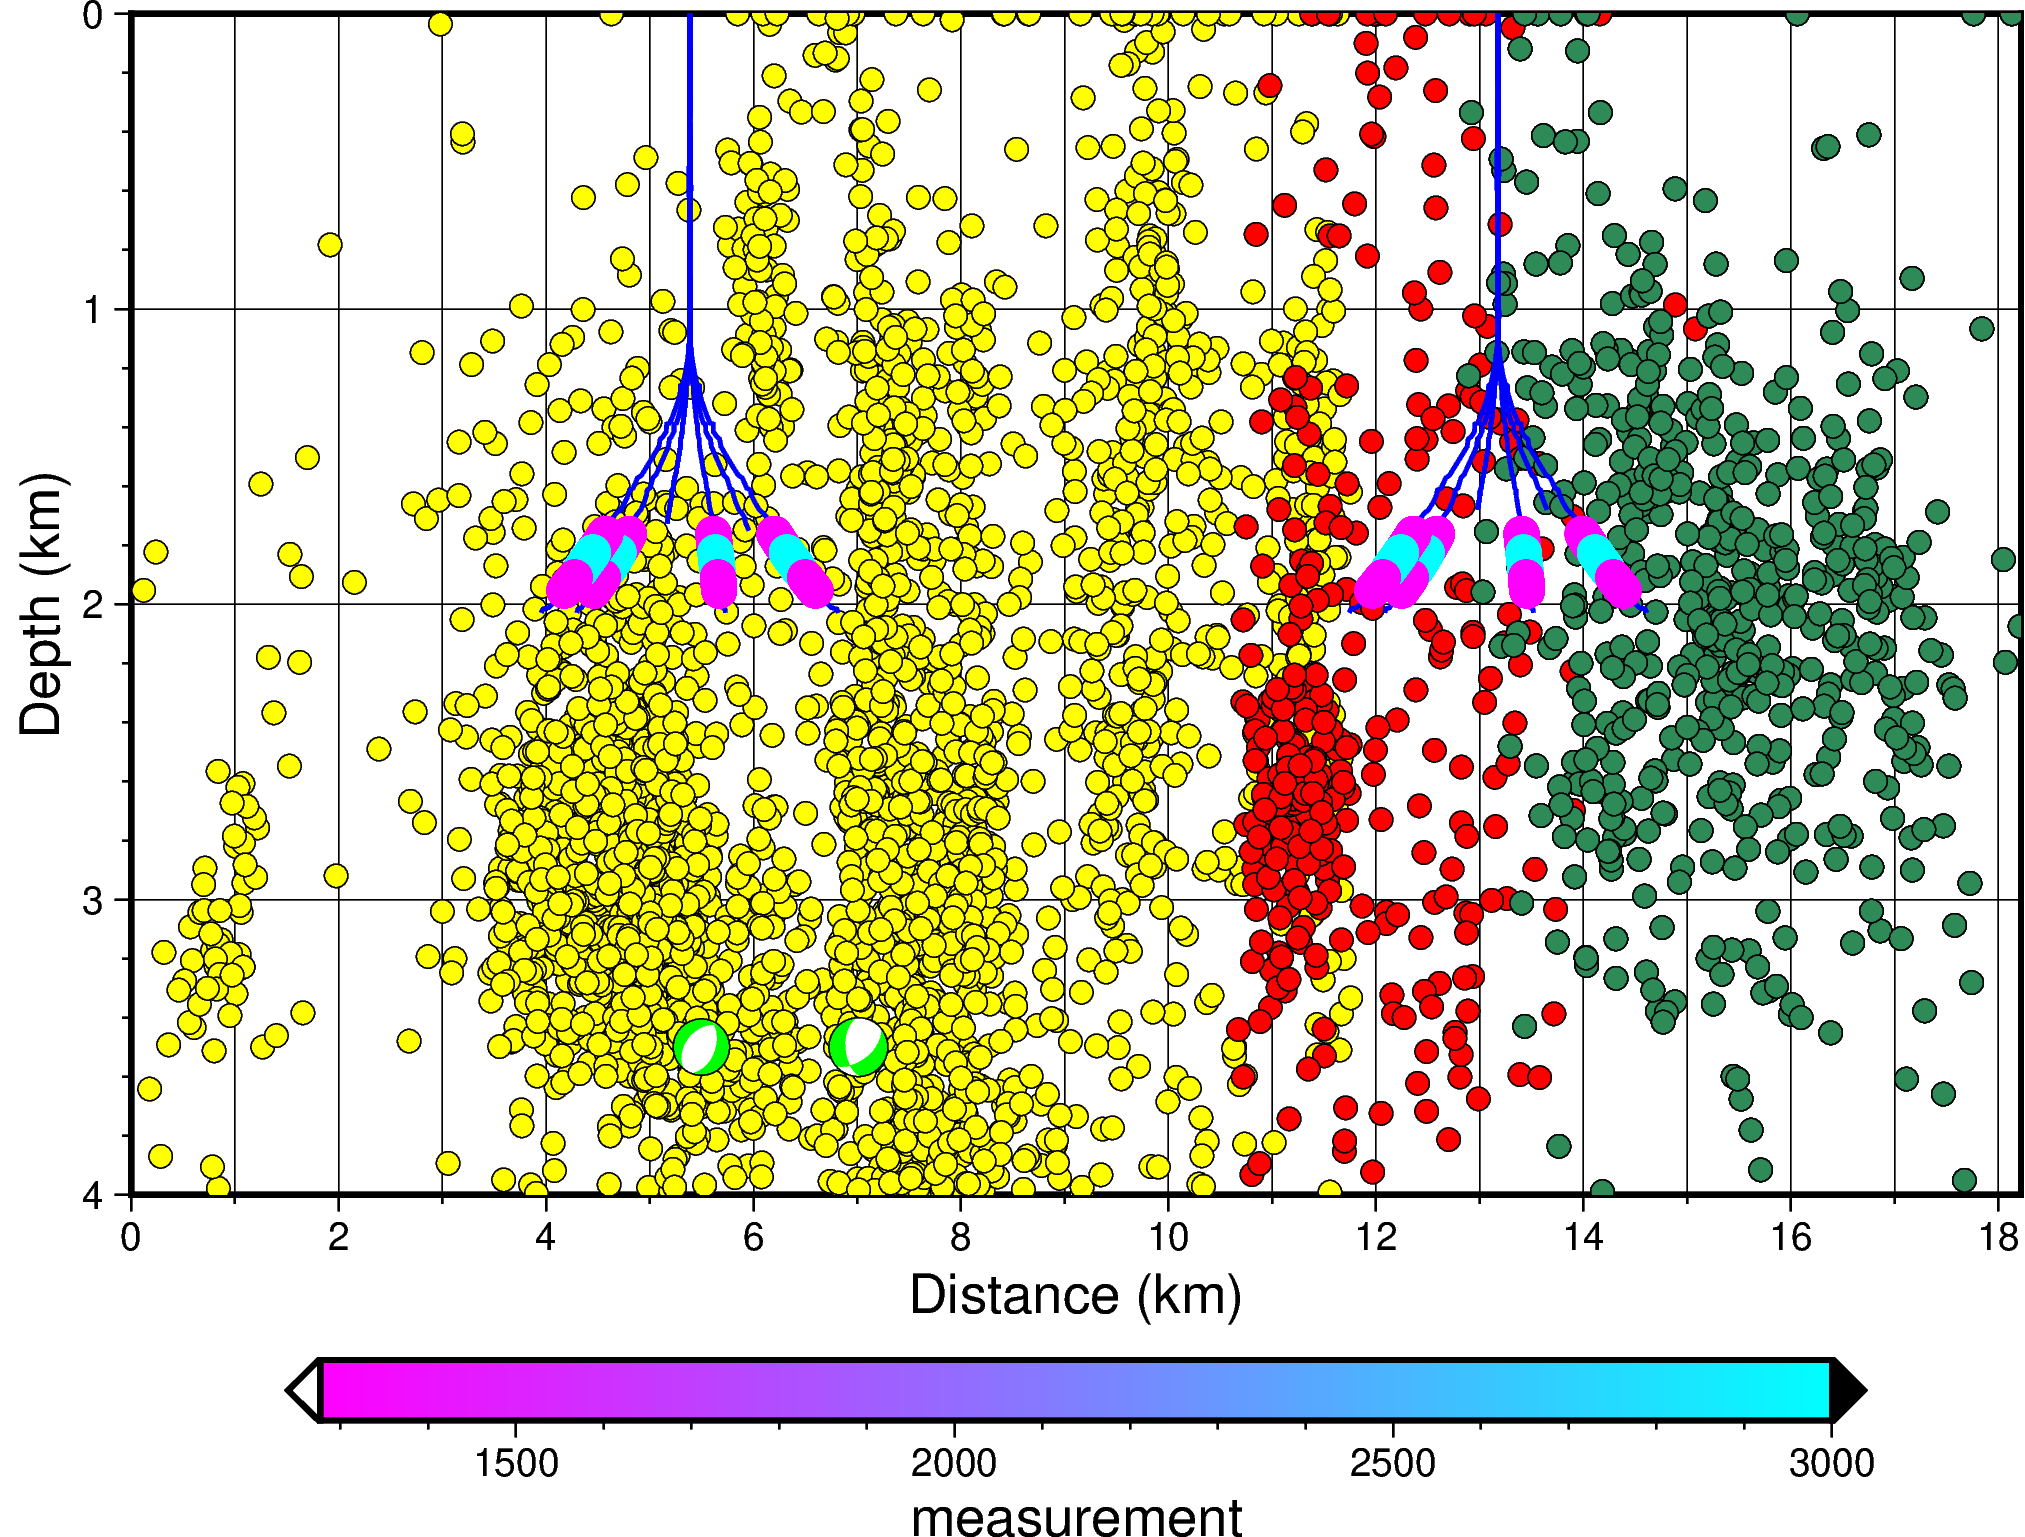

In [16]:

otherbaseprofile = BaseProfile(projection="X16c/-10c",depth_lims =[0,4],
                        grid=(1,1),
                        output_unit="km")
otherprofile = Profile(name=("A","A'"),      
            coords=((-122.88243,38.85673),(-122.69410,38.78445)),
            width=(-1.5,1.55),
            baseprofile=otherbaseprofile
                )
otherprofile.add_mulobject(othermulcatalog,depth_unit="km")
otherprofile.add_mulobject(mulwell,depth_unit="m")
otherprofile.add_mulobject(mulfm,depth_unit="km")
otherprofig = otherprofile.plot()
otherprofig.savefig(os.path.join(rep_out,"profile.png"))
otherprofig.show()

# Utilities

You can obtain projected data with the next line

In [17]:
print(profile.mulobjects)

{'MulCatalog': {'projections': [       distance  depth          origin_time  magnitude
0      5.266214  3.511  2016-01-01T00:44:48       0.11
1     13.873366  5.363  2016-01-01T01:16:26       0.57
2     11.969400  3.923  2016-01-01T01:18:05       0.25
3     15.030149  2.027  2016-01-01T01:46:37       0.78
4      7.258237  3.041  2016-01-01T01:46:47       0.28
...         ...    ...                  ...        ...
4690   6.110543  0.695  2016-03-10T12:23:20       1.02
4691   7.573589  3.328  2016-03-10T12:28:02       1.12
4692   7.513569  3.944  2016-03-10T12:29:55       0.65
4693  11.373974  2.768  2016-03-10T13:08:33       0.21
4694   7.850941  3.897  2016-03-10T13:17:53       1.20

[4695 rows x 4 columns]], 'baseplots': [<EQViewer.eqviewer.BasePlot object at 0x7ff05662faf0>], 'cpt': <EQViewer.eqviewer.CPT object at 0x7ff05662fa30>, 'show_cpt': True}, 'MulWell': {'projections': [     distance     depth          TVD    MD
0   13.176501 -0.078709     0.000000     0
1   13.176992 -0.0406

Even [MulCatalog](https://github.com/ecastillot/EQViewer/blob/master/examples/3_catalog.ipynb), [MullWell](https://github.com/ecastillot/EQViewer/blob/master/examples/4_well.ipynb) and [MulFM](https://github.com/ecastillot/EQViewer/blob/master/examples/5_fm.ipynb) have project method available. If you want to obtain the projected data, you can use this util method

In [18]:
data = mulcatalog.project(startpoint=(-122.88243,38.85673),
                        endpoint=(-122.69410,38.78445),
                        width=(-1.5,1.55),)
print(data)

project [INFORMATION]: Processing input table data
project [INFORMATION]: Reading Data Table from Input memory location via vector
project [INFORMATION]: Writing Data Table to file /tmp/pygmt-g_1uvflo.csv
project [INFORMATION]: 9998 read, 4695 used


[       distance  depth          origin_time  magnitude
0      5.266214  3.511  2016-01-01T00:44:48       0.11
1     13.873366  5.363  2016-01-01T01:16:26       0.57
2     11.969400  3.923  2016-01-01T01:18:05       0.25
3     15.030149  2.027  2016-01-01T01:46:37       0.78
4      7.258237  3.041  2016-01-01T01:46:47       0.28
...         ...    ...                  ...        ...
4690   6.110543  0.695  2016-03-10T12:23:20       1.02
4691   7.573589  3.328  2016-03-10T12:28:02       1.12
4692   7.513569  3.944  2016-03-10T12:29:55       0.65
4693  11.373974  2.768  2016-03-10T13:08:33       0.21
4694   7.850941  3.897  2016-03-10T13:17:53       1.20

[4695 rows x 4 columns]]
